In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt

ahora = datetime.now().strftime('%Y-%m-%d')

Ticket = 'QQQ'

# Descargar los datos de QQQ
data = yf.download(Ticket, start="2023-01-01", end=ahora,interval='1d')

# Obtener los rendimientos diarios
returns = data['Adj Close'].pct_change().dropna()

# Configurar las simulaciones
n_simulations = 10
n_days = len(returns)

# Realizar las simulaciones de bootstrap
bootstrap_samples = np.random.choice(returns, (n_simulations, n_days), replace=True)
bootstrap_cumulated = np.cumprod(1 + bootstrap_samples, axis=1)

# Calcular el precio simulado para cada muestra de bootstrap
simulated_prices = bootstrap_cumulated * data['Adj Close'].iloc[0]

# Crear un DataFrame para las simulaciones
simulated_df = pd.DataFrame(simulated_prices.T)
simulated_df.set_index(data.index[:-1],inplace=True)

# Graficar las simulaciones
fig = go.Figure()

# Agregar líneas para cada simulación
for i in range(n_simulations):
    fig.add_trace(go.Scatter(x=data.index, y=simulated_df[i], mode='lines', line=dict(width=2), opacity=0.3))

# Agregar línea del precio real
fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], mode='lines', name='Real', line=dict(color='black', width=2)))

# Configurar el gráfico
fig.update_layout(title=f'Simulaciones de Bootstrap para {Ticket}',
                  xaxis_title='Fecha',
                  yaxis_title='Precio Ajustado',
                  template='plotly_white')

# Mostrar el gráfico
fig.show()


[*********************100%%**********************]  1 of 1 completed


In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller

def analyze_residuals(prices: pd.Series):
    # Calcular retornos logarítmicos
    returns = np.log(prices / prices.shift(1)).dropna()

    # Crear un DataFrame con los retornos
    data = pd.DataFrame({'Returns': returns})

    # Ajustar un modelo de regresión lineal simple
    data['Time'] = np.arange(len(data))
    X = sm.add_constant(data['Time'])
    model = sm.OLS(data['Returns'], X).fit()
    data['Fitted'] = model.fittedvalues
    data['Residuals'] = model.resid

    # Mostrar resumen del modelo
    print("Resumen del Modelo:")
    print(model.summary())

    # Análisis de residuos
    residuals = data['Residuals']

    # 1. Normalidad de los residuos
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=residuals, nbinsx=20, name='Residuals', marker=dict(color='rgba(0, 123, 255, 0.7)')))
    fig.update_layout(title='Histograma de Residuos', xaxis_title='Residuo', yaxis_title='Frecuencia', bargap=0.1)
    fig.show()

    # Prueba de normalidad de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = shapiro(residuals)
    print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p_value:.4f}")
    if shapiro_p_value > 0.05:
        print("Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).")
    else:
        print("Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).")

    # Gráfico Q-Q
    qq = probplot(residuals, dist="norm")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='Datos'))
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', name='Línea de referencia'))
    fig.update_layout(title='Gráfico Q-Q de Residuos', xaxis_title='Cuantiles Teóricos', yaxis_title='Cuantiles de Datos')
    fig.show()

    # 2. Homocedasticidad
    fig = px.scatter(data, x='Fitted', y='Residuals', title='Gráfico de Residuos vs. Valores Ajustados')
    fig.add_shape(type='line', x0=data['Fitted'].min(), x1=data['Fitted'].max(), y0=0, y1=0, line=dict(color='red', dash='dash'))
    fig.update_layout(xaxis_title='Valores Ajustados', yaxis_title='Residuos')
    fig.show()

    # Prueba de heterocedasticidad de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"Prueba de Breusch-Pagan: Estadístico = {bp_test[0]:.4f}, p-valor = {bp_test[1]:.4f}")
    if bp_test[1] > 0.05:
        print("Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de heterocedasticidad (p-valor <= 0.05).")

    # 3. Independencia y autocorrelación de residuos
    fig = px.line(data, x=data.index, y='Residuals', title='Serie Temporal de Residuos')
    fig.update_layout(xaxis_title='Índice', yaxis_title='Residuo')
    fig.show()

    # Prueba de autocorrelación de Breusch-Godfrey
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Prueba de Breusch-Godfrey: Estadístico = {bg_test[0]:.4f}, p-valor = {bg_test[1]:.4f}")
    if bg_test[1] > 0.05:
        print("Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de autocorrelación (p-valor <= 0.05).")

    # ADF Test para verificar si la serie de residuos es estacionaria
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
    print(f"Prueba de ADF (Dickey-Fuller): Estadístico = {adf_stat:.4f}, p-valor = {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("Interpretación: Los residuos son estacionarios (p-valor <= 0.05).")
    else:
        print("Interpretación: Los residuos no son estacionarios (p-valor > 0.05).")

# Ejemplo de uso con una serie de precios ficticia
fechas = pd.date_range(start='2024-01-01', periods=100)
precios = pd.Series(np.cumsum(np.random.normal(0, 1, 100)) + 100, index=fechas)

analyze_residuals(precios)


Resumen del Modelo:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5186
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.473
Time:                        10:12:53   Log-Likelihood:                 320.75
No. Observations:                  99   AIC:                            -637.5
Df Residuals:                      97   BIC:                            -632.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002

Prueba de Shapiro-Wilk: Estadístico = 0.9896, p-valor = 0.6396
Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).


Prueba de Breusch-Pagan: Estadístico = 2.4646, p-valor = 0.1164
Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).


Prueba de Breusch-Godfrey: Estadístico = 1.3356, p-valor = 0.9312
Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).
Prueba de ADF (Dickey-Fuller): Estadístico = -9.1391, p-valor = 0.0000
Interpretación: Los residuos son estacionarios (p-valor <= 0.05).


In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller, acf, pacf

def analyze_residuals(prices: pd.Series):
    # Calcular retornos logarítmicos
    returns = np.log(prices / prices.shift(1)).dropna()

    # Crear un DataFrame con los retornos
    data = pd.DataFrame({'Returns': returns})

    # Ajustar un modelo de regresión lineal simple
    data['Time'] = np.arange(len(data))
    X = sm.add_constant(data['Time'])
    model = sm.OLS(data['Returns'], X).fit()
    data['Fitted'] = model.fittedvalues
    data['Residuals'] = model.resid

    # Mostrar resumen del modelo
    print("Resumen del Modelo:")
    print(model.summary())

    # Análisis de residuos
    residuals = data['Residuals']

    # 1. Normalidad de los residuos
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=residuals, nbinsx=20, name='Residuals', marker=dict(color='rgba(0, 123, 255, 0.7)')))
    fig.update_layout(title='Histograma de Residuos', xaxis_title='Residuo', yaxis_title='Frecuencia', bargap=0.1)
    fig.show()

    # Prueba de normalidad de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = shapiro(residuals)
    print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p_value:.4f}")
    if shapiro_p_value > 0.05:
        print("Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).")
    else:
        print("Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).")

    # Gráfico Q-Q
    qq = probplot(residuals, dist="norm")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='Datos'))
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', name='Línea de referencia'))
    fig.update_layout(title='Gráfico Q-Q de Residuos', xaxis_title='Cuantiles Teóricos', yaxis_title='Cuantiles de Datos')
    fig.show()

    # 2. Homocedasticidad
    fig = px.scatter(data, x='Fitted', y='Residuals', title='Gráfico de Residuos vs. Valores Ajustados')
    fig.add_shape(type='line', x0=data['Fitted'].min(), x1=data['Fitted'].max(), y0=0, y1=0, line=dict(color='red', dash='dash'))
    fig.update_layout(xaxis_title='Valores Ajustados', yaxis_title='Residuos')
    fig.show()

    # Prueba de heterocedasticidad de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"Prueba de Breusch-Pagan: Estadístico = {bp_test[0]:.4f}, p-valor = {bp_test[1]:.4f}")
    if bp_test[1] > 0.05:
        print("Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de heterocedasticidad (p-valor <= 0.05).")

    # 3. Independencia y autocorrelación de residuos
    fig = px.line(data, x=data.index, y='Residuals', title='Serie Temporal de Residuos')
    fig.update_layout(xaxis_title='Índice', yaxis_title='Residuo')
    fig.show()

    # Correlograma de los residuos
    acf_values = acf(residuals, nlags=20)
    pacf_values = pacf(residuals, nlags=20)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=np.arange(len(acf_values)), y=acf_values, name='ACF', marker=dict(color='rgba(255, 99, 71, 0.7)')))
    fig.add_trace(go.Bar(x=np.arange(len(pacf_values)), y=pacf_values, name='PACF', marker=dict(color='rgba(71, 99, 255, 0.7)')))
    fig.update_layout(title='Correlograma de Residuos', xaxis_title='Lag', yaxis_title='Autocorrelación', barmode='overlay')
    fig.show()

    # Prueba de autocorrelación de Breusch-Godfrey
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Prueba de Breusch-Godfrey: Estadístico = {bg_test[0]:.4f}, p-valor = {bg_test[1]:.4f}")
    if bg_test[1] > 0.05:
        print("Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de autocorrelación (p-valor <= 0.05).")

    # ADF Test para verificar si la serie de residuos es estacionaria
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
    print(f"Prueba de ADF (Dickey-Fuller): Estadístico = {adf_stat:.4f}, p-valor = {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("Interpretación: Los residuos son estacionarios (p-valor <= 0.05).")
    else:
        print("Interpretación: Los residuos no son estacionarios (p-valor > 0.05).")

# Ejemplo de uso con una serie de precios ficticia
fechas = pd.date_range(start='2024-01-01', periods=100)
precios = pd.Series(np.cumsum(np.random.normal(0, 1, 100)) + 100, index=fechas)

analyze_residuals(precios)


Resumen del Modelo:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.08453
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.772
Time:                        10:16:06   Log-Likelihood:                 333.45
No. Observations:                  99   AIC:                            -662.9
Df Residuals:                      97   BIC:                            -657.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002

Prueba de Shapiro-Wilk: Estadístico = 0.9733, p-valor = 0.0414
Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).


Prueba de Breusch-Pagan: Estadístico = 1.6914, p-valor = 0.1934
Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).


Prueba de Breusch-Godfrey: Estadístico = 5.5171, p-valor = 0.3561
Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).
Prueba de ADF (Dickey-Fuller): Estadístico = -10.4256, p-valor = 0.0000
Interpretación: Los residuos son estacionarios (p-valor <= 0.05).


In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller, acf, pacf

def analyze_residuals(prices: pd.Series):
    # Calcular retornos logarítmicos
    returns = np.log(prices / prices.shift(1)).dropna()

    # Crear un DataFrame con los retornos
    data = pd.DataFrame({'Returns': returns})

    # Ajustar un modelo de regresión lineal simple
    data['Time'] = np.arange(len(data))
    X = sm.add_constant(data['Time'])
    model = sm.OLS(data['Returns'], X).fit()
    data['Fitted'] = model.fittedvalues
    data['Residuals'] = model.resid

    # Mostrar resumen del modelo
    print("Resumen del Modelo:")
    print(model.summary())

    # Análisis de residuos
    residuals = data['Residuals']

    # 1. Normalidad de los residuos
    hist_fig = go.Histogram(x=residuals, nbinsx=20, name='Residuals', marker=dict(color='rgba(0, 123, 255, 0.7)'))

    # Prueba de normalidad de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = shapiro(residuals)
    print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p_value:.4f}")
    if shapiro_p_value > 0.05:
        print("Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).")
    else:
        print("Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).")

    # Gráfico Q-Q
    qq = probplot(residuals, dist="norm")
    qq_fig = go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='Datos')
    qq_line = go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', name='Línea de referencia')

    # 2. Homocedasticidad
    scatter_fig = go.Scatter(x=data['Fitted'], y=residuals, mode='markers', name='Residuos')
    scatter_line = go.Scatter(x=[data['Fitted'].min(), data['Fitted'].max()], y=[0, 0], mode='lines', name='Línea 0', line=dict(color='red', dash='dash'))

    # Prueba de heterocedasticidad de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"Prueba de Breusch-Pagan: Estadístico = {bp_test[0]:.4f}, p-valor = {bp_test[1]:.4f}")
    if bp_test[1] > 0.05:
        print("Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de heterocedasticidad (p-valor <= 0.05).")

    # 3. Independencia y autocorrelación de residuos
    line_fig = go.Scatter(x=data.index, y=residuals, mode='lines', name='Serie Temporal de Residuos')

    # Correlograma de los residuos
    acf_values = acf(residuals, nlags=20)
    pacf_values = pacf(residuals, nlags=20)

    acf_fig = go.Bar(x=np.arange(len(acf_values)), y=acf_values, name='ACF', marker=dict(color='rgba(255, 99, 71, 0.7)'))
    pacf_fig = go.Bar(x=np.arange(len(pacf_values)), y=pacf_values, name='PACF', marker=dict(color='rgba(71, 99, 255, 0.7)'))

    # Prueba de autocorrelación de Breusch-Godfrey
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Prueba de Breusch-Godfrey: Estadístico = {bg_test[0]:.4f}, p-valor = {bg_test[1]:.4f}")
    if bg_test[1] > 0.05:
        print("Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de autocorrelación (p-valor <= 0.05).")

    # ADF Test para verificar si la serie de residuos es estacionaria
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
    print(f"Prueba de ADF (Dickey-Fuller): Estadístico = {adf_stat:.4f}, p-valor = {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("Interpretación: Los residuos son estacionarios (p-valor <= 0.05).")
    else:
        print("Interpretación: Los residuos no son estacionarios (p-valor > 0.05).")

    # Crear subplots
    fig = make_subplots(rows=3, cols=2, 
                        subplot_titles=("Histograma de Residuos", "Gráfico Q-Q de Residuos",
                                        "Residuos vs. Valores Ajustados", "Serie Temporal de Residuos",
                                        "Correlograma ACF", "Correlograma PACF"))

    # Añadir gráficos
    fig.add_trace(hist_fig, row=1, col=1)
    fig.add_trace(qq_fig, row=1, col=2)
    fig.add_trace(qq_line, row=1, col=2)
    fig.add_trace(scatter_fig, row=2, col=1)
    fig.add_trace(scatter_line, row=2, col=1)
    fig.add_trace(line_fig, row=2, col=2)
    fig.add_trace(acf_fig, row=3, col=1)
    fig.add_trace(pacf_fig, row=3, col=2)

    # Actualizar layout
    fig.update_layout(title='Análisis de Residuos', showlegend=False, height=900)

    # Mostrar figura
    fig.show()

# Ejemplo de uso con una serie de precios ficticia
fechas = pd.date_range(start='2024-01-01', periods=100)
precios = pd.Series(np.cumsum(np.random.normal(0, 1, 100)) + 100, index=fechas)

analyze_residuals(precios)


Resumen del Modelo:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3039
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.583
Time:                        10:18:35   Log-Likelihood:                 322.98
No. Observations:                  99   AIC:                            -642.0
Df Residuals:                      97   BIC:                            -636.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002

In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller, acf, pacf

def analyze_residuals(prices: pd.Series):
    # Calcular retornos logarítmicos
    returns = np.log(prices / prices.shift(1)).dropna()

    # Crear un DataFrame con los retornos
    data = pd.DataFrame({'Returns': returns})

    # Ajustar un modelo de regresión lineal simple
    data['Time'] = np.arange(len(data))
    X = sm.add_constant(data['Time'])
    model = sm.OLS(data['Returns'], X).fit()
    data['Fitted'] = model.fittedvalues
    data['Residuals'] = model.resid

    # Mostrar resumen del modelo
    print("Resumen del Modelo:")
    print(model.summary())

    # Análisis de residuos
    residuals = data['Residuals']

    # 1. Normalidad de los residuos
    hist_fig = go.Histogram(x=residuals, nbinsx=20, name='Residuals', marker=dict(color='rgba(0, 123, 255, 0.7)'))

    # Prueba de normalidad de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = shapiro(residuals)
    print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p_value:.4f}")
    if shapiro_p_value > 0.05:
        print("Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).")
    else:
        print("Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).")

    # Gráfico Q-Q
    qq = probplot(residuals, dist="norm")
    qq_fig = go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='Datos')
    qq_line = go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', name='Línea de referencia')

    # 2. Homocedasticidad
    scatter_fig = go.Scatter(x=data['Fitted'], y=residuals, mode='markers', name='Residuos')
    scatter_line = go.Scatter(x=[data['Fitted'].min(), data['Fitted'].max()], y=[0, 0], mode='lines', name='Línea 0', line=dict(color='red', dash='dash'))

    # Prueba de heterocedasticidad de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"Prueba de Breusch-Pagan: Estadístico = {bp_test[0]:.4f}, p-valor = {bp_test[1]:.4f}")
    if bp_test[1] > 0.05:
        print("Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de heterocedasticidad (p-valor <= 0.05).")

    # 3. Independencia y autocorrelación de residuos
    line_fig = go.Scatter(x=data.index, y=residuals, mode='lines', name='Serie Temporal de Residuos')

    # Correlograma de los residuos
    acf_values = acf(residuals, nlags=20)
    pacf_values = pacf(residuals, nlags=20)

    acf_fig = go.Bar(x=np.arange(len(acf_values)), y=acf_values, name='ACF', marker=dict(color='rgba(255, 99, 71, 0.7)'))
    pacf_fig = go.Bar(x=np.arange(len(pacf_values)), y=pacf_values, name='PACF', marker=dict(color='rgba(71, 99, 255, 0.7)'))

    # Prueba de autocorrelación de Breusch-Godfrey
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Prueba de Breusch-Godfrey: Estadístico = {bg_test[0]:.4f}, p-valor = {bg_test[1]:.4f}")
    if bg_test[1] > 0.05:
        print("Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de autocorrelación (p-valor <= 0.05).")

    # ADF Test para verificar si la serie de residuos es estacionaria
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
    print(f"Prueba de ADF (Dickey-Fuller): Estadístico = {adf_stat:.4f}, p-valor = {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("Interpretación: Los residuos son estacionarios (p-valor <= 0.05).")
    else:
        print("Interpretación: Los residuos no son estacionarios (p-valor > 0.05).")

    # Crear subplots
    fig = make_subplots(rows=3, cols=2, 
                        subplot_titles=("Histograma de Residuos", "Gráfico Q-Q de Residuos",
                                        "Residuos vs. Valores Ajustados", "Serie Temporal de Residuos",
                                        "Correlograma ACF", "Correlograma PACF"))

    # Añadir gráficos
    fig.add_trace(hist_fig, row=1, col=1)
    fig.add_trace(qq_fig, row=1, col=2)
    fig.add_trace(qq_line, row=1, col=2)
    fig.add_trace(scatter_fig, row=2, col=1)
    fig.add_trace(scatter_line, row=2, col=1)
    fig.add_trace(line_fig, row=2, col=2)
    fig.add_trace(acf_fig, row=3, col=1)
    fig.add_trace(pacf_fig, row=3, col=2)

    # Actualizar layout
    fig.update_layout(title='Análisis de Residuos', template='plotly_white', showlegend=False, height=900)

    # Mostrar figura
    fig.show()

# Ejemplo de uso con una serie de precios ficticia
fechas = pd.date_range(start='2024-01-01', periods=100)
precios = pd.Series(np.cumsum(np.random.normal(0, 1, 100)) + 100, index=fechas)

analyze_residuals(returns)


Resumen del Modelo:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.220
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.271
Time:                        10:30:28   Log-Likelihood:                -401.98
No. Observations:                 214   AIC:                             808.0
Df Residuals:                     212   BIC:                             814.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2277      0.217

/Users/luis/Desktop/UNIVERSIDAD/Simulación/Hawkes/HawkesEnv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller, acf, pacf

def analyze_residuals(prices: pd.Series):
    # Calcular retornos logarítmicos
    returns = np.log(prices / prices.shift(1)).dropna()

    # Crear un DataFrame con los retornos
    data = pd.DataFrame({'Returns': returns})

    # Ajustar un modelo de regresión lineal simple
    data['Time'] = np.arange(len(data))
    X = sm.add_constant(data['Time'])
    model = sm.OLS(data['Returns'], X).fit()
    data['Fitted'] = model.fittedvalues
    data['Residuals'] = model.resid

    # Mostrar resumen del modelo
    print("Resumen del Modelo:")
    print(model.summary())

    # Análisis de residuos
    residuals = data['Residuals']

    # 1. Normalidad de los residuos
    hist_fig = go.Histogram(x=residuals, nbinsx=20, name='Residuals', marker=dict(color='rgba(0, 123, 255, 0.7)'))

    # Prueba de normalidad de Shapiro-Wilk
    shapiro_stat, shapiro_p_value = shapiro(residuals)
    print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p_value:.4f}")
    if shapiro_p_value > 0.05:
        print("Interpretación: Los residuos siguen una distribución normal (p-valor > 0.05).")
    else:
        print("Interpretación: Los residuos no siguen una distribución normal (p-valor <= 0.05).")

    # Gráfico Q-Q
    qq = probplot(residuals, dist="norm")
    qq_theoretical = qq[0][0]
    qq_empirical = qq[0][1]
    qq_fig = go.Scatter(x=qq_theoretical, y=qq_empirical, mode='markers', name='Datos')
    qq_line = go.Scatter(x=qq_theoretical, y=qq_theoretical, mode='lines', name='Línea de referencia', line=dict(color='red'))

    # 2. Homocedasticidad
    scatter_fig = go.Scatter(x=data['Fitted'], y=residuals, mode='markers', name='Residuos')
    scatter_line = go.Scatter(x=[data['Fitted'].min(), data['Fitted'].max()], y=[0, 0], mode='lines', name='Línea 0', line=dict(color='red', dash='dash'))

    # Prueba de heterocedasticidad de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X)
    print(f"Prueba de Breusch-Pagan: Estadístico = {bp_test[0]:.4f}, p-valor = {bp_test[1]:.4f}")
    if bp_test[1] > 0.05:
        print("Interpretación: No hay evidencia de heterocedasticidad (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de heterocedasticidad (p-valor <= 0.05).")

    # 3. Independencia y autocorrelación de residuos
    line_fig = go.Scatter(x=data.index, y=residuals, mode='lines', name='Serie Temporal de Residuos')

    # Correlograma de los residuos
    acf_values = acf(residuals, nlags=20)
    pacf_values = pacf(residuals, nlags=20)

    acf_fig = go.Bar(x=np.arange(len(acf_values)), y=acf_values, name='ACF', marker=dict(color='rgba(255, 99, 71, 0.7)'))
    pacf_fig = go.Bar(x=np.arange(len(pacf_values)), y=pacf_values, name='PACF', marker=dict(color='rgba(71, 99, 255, 0.7)'))

    # Prueba de autocorrelación de Breusch-Godfrey
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Prueba de Breusch-Godfrey: Estadístico = {bg_test[0]:.4f}, p-valor = {bg_test[1]:.4f}")
    if bg_test[1] > 0.05:
        print("Interpretación: No hay evidencia de autocorrelación (p-valor > 0.05).")
    else:
        print("Interpretación: Hay evidencia de autocorrelación (p-valor <= 0.05).")

    # ADF Test para verificar si la serie de residuos es estacionaria
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
    print(f"Prueba de ADF (Dickey-Fuller): Estadístico = {adf_stat:.4f}, p-valor = {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("Interpretación: Los residuos son estacionarios (p-valor <= 0.05).")
    else:
        print("Interpretación: Los residuos no son estacionarios (p-valor > 0.05).")

    # Crear subplots
    fig = make_subplots(rows=3, cols=2, 
                        subplot_titles=("Histograma de Residuos", "Gráfico Q-Q de Residuos",
                                        "Residuos vs. Valores Ajustados", "Serie Temporal de Residuos",
                                        "Correlograma ACF", "Correlograma PACF"))

    # Añadir gráficos
    fig.add_trace(hist_fig, row=1, col=1)
    fig.add_trace(qq_fig, row=1, col=2)
    fig.add_trace(qq_line, row=1, col=2)
    fig.add_trace(scatter_fig, row=2, col=1)
    fig.add_trace(scatter_line, row=2, col=1)
    fig.add_trace(line_fig, row=2, col=2)
    fig.add_trace(acf_fig, row=3, col=1)
    fig.add_trace(pacf_fig, row=3, col=2)

    # Actualizar layout
    fig.update_layout(title='Análisis de Residuos', template='plotly_white', showlegend=False, height=900)

    # Mostrar figura
    fig.show()

# Ejemplo de uso con una serie de precios ficticia
fechas = pd.date_range(start='2024-01-01', periods=100)
precios = pd.Series(np.cumsum(np.random.normal(0, 1, 100)) + 100, index=fechas)

analyze_residuals(returns)


Resumen del Modelo:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.220
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.271
Time:                        10:29:58   Log-Likelihood:                -401.98
No. Observations:                 214   AIC:                             808.0
Df Residuals:                     212   BIC:                             814.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2277      0.217

/Users/luis/Desktop/UNIVERSIDAD/Simulación/Hawkes/HawkesEnv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



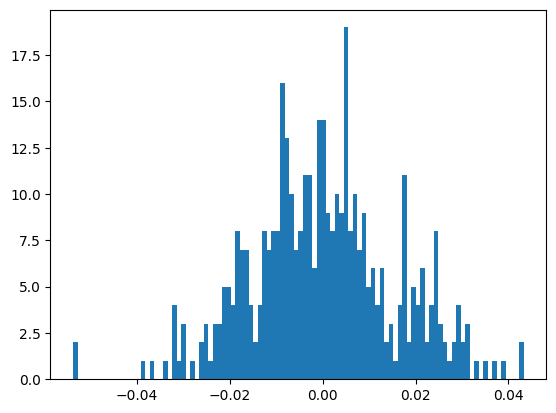

In [17]:
import pandas as pd
import plotly.express as px

plt.hist(returns.diff(),bins=100)

# Crear el histograma usando Plotly
fig = px.histogram(returns.diff(), nbins=100, title='Histograma de Diferencias',
                   labels={'value': 'Diferencia'}, 
                   template='plotly_white')

# Mostrar el histograma
fig.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  3.,  1.,  0.,  2.,  1.,  2.,  1.,  4.,  2.,  4.,
         4.,  2.,  3.,  5.,  3.,  4.,  4.,  1.,  5.,  4.,  4.,  9.,  3.,
         7.,  7.,  7.,  8.,  6.,  5., 13.,  8., 12., 10., 13., 14., 15.,
        13., 16.,  8., 10., 10., 11.,  7., 10.,  8., 11.,  2.,  8.,  7.,
         7., 12.,  5.,  2.,  4.,  4.,  5.,  3.,  6.,  2.,  4.,  0.,  4.,
         4.,  3.,  2.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.58703142e-02, -3.51527106e-02, -3.44351070e-02, -3.37175033e-02,
        -3.29998997e-02, -3.22822961e-02, -3.15646925e-02, -3.08470889e-02,
        -3.01294853e-02, -2.94118816e-02, -2.86942780e-02, -2.79766744e-02,
        -2.72590708e-02, -2.65414672e-02, -2.58238636e-02, -2.51062599e-02,
        -2.43886563e-02, -2.36710527e-02, -2.29534491e-02, -2.22358455e-02,
        -2.15182419e-02, -2.08006382e-02, -2.00830346e

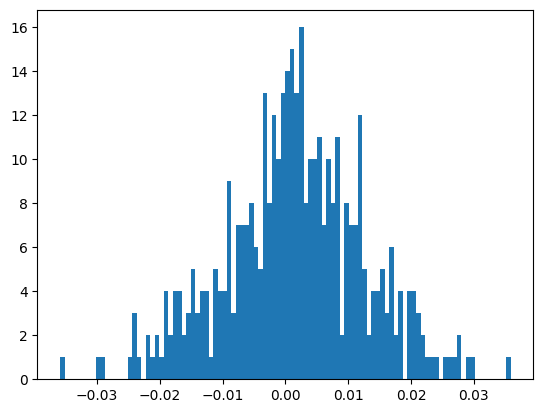

In [8]:
plt.hist(returns,bins=100)

In [19]:
import pandas as pd
from scipy.stats import shapiro

valores = returns.diff()

# Prueba de Shapiro-Wilk
stat, p_value = shapiro(valores)
print('Estadístico de Shapiro-Wilk:', stat)
print('Valor p:', p_value)

if p_value > 0.05:
    print("Los datos parecen seguir una distribución normal (no se rechaza H0)")
else:
    print("Los datos no siguen una distribución normal (se rechaza H0)")
    
from scipy.stats import anderson

# Prueba de Anderson-Darling
result = anderson(valores)
print('Estadístico de Anderson-Darling:', result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f"{sl}%: {cv}, Los datos parecen seguir una distribución normal (no se rechaza H0)")
    else:
        print(f"{sl}%: {cv}, Los datos no siguen una distribución normal (se rechaza H0)")
    
from scipy.stats import kstest

# Prueba de Kolmogorov-Smirnov
stat, p_value = kstest(valores, 'norm', args=(valores.mean(), valores.std()))
print('Estadístico de Kolmogorov-Smirnov:', stat)
print('Valor p:', p_value)

if p_value > 0.05:
    print("Los datos parecen seguir una distribución normal (no se rechaza H0)")
else:
    print("Los datos no siguen una distribución normal (se rechaza H0)")

Estadístico de Shapiro-Wilk: nan
Valor p: nan
Los datos no siguen una distribución normal (se rechaza H0)
Estadístico de Anderson-Darling: nan
15.0%: 0.57, Los datos no siguen una distribución normal (se rechaza H0)
10.0%: 0.65, Los datos no siguen una distribución normal (se rechaza H0)
5.0%: 0.779, Los datos no siguen una distribución normal (se rechaza H0)
2.5%: 0.909, Los datos no siguen una distribución normal (se rechaza H0)
1.0%: 1.081, Los datos no siguen una distribución normal (se rechaza H0)
Estadístico de Kolmogorov-Smirnov: nan
Valor p: nan
Los datos no siguen una distribución normal (se rechaza H0)


In [10]:
import pingouin as pg

# Prueba de Lilliefors
result = pg.normality(data)
print(result)

                  W          pval  normal
Open       0.972299  6.689464e-07   False
High       0.971551  4.855245e-07   False
Low        0.972511  7.333517e-07   False
Close      0.972228  6.488184e-07   False
Adj Close  0.971579  4.913140e-07   False
Volume     0.983993  2.084919e-04   False


In [21]:
import yfinance as yf
import plotly.graph_objects as go

# Descargar datos de acciones
ticker = "AAPL"  # Cambia esto por el símbolo de la acción que desees
data = yf.download(ticker, start="2023-01-01", end="2023-07-01")

# Comprobar los datos descargados
print(data.head())

# Crear el gráfico de velas japonesas
fig = go.Figure(data=[go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    increasing_line_color='green', 
    decreasing_line_color='red',
    showlegend=True
)])

# Configurar el diseño del gráfico
fig.update_layout(
    title=f'Gráfico de Velas Japonesas para {ticker}',
    xaxis_title='Fecha',
    yaxis_title='Precio ($)',
    xaxis_rangeslider_visible=False  # Ocultar el control deslizante de rango
)

# Mostrar el gráfico
fig.show()


[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048042   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327507   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998459   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560852   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086533   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048042   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327507   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998459   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560852   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086533   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


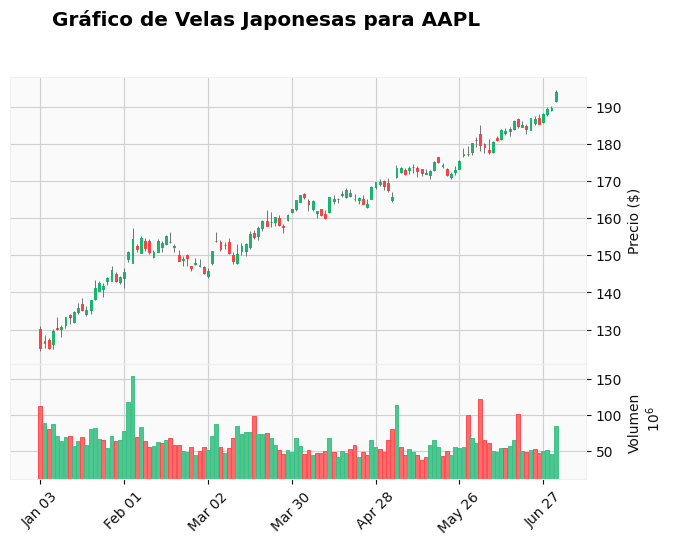

In [12]:
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt

# Descargar datos de acciones
ticker = "AAPL"  # Puedes cambiarlo por el símbolo de la acción que desees
data = yf.download(ticker, start="2023-01-01", end="2023-07-01")

# Comprobar los datos descargados
print(data.head())

# Configurar el estilo del gráfico
mpf_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 10})

# Crear el gráfico de velas japonesas
mpf.plot(
    data,
    type='candle',
    volume=True,
    title=f'Gráfico de Velas Japonesas para {ticker}',
    style=mpf_style,
    ylabel='Precio ($)',
    ylabel_lower='Volumen'
)

# Mostrar el gráfico
plt.show()

In [46]:
volatility = np.std(returns, ddof=1)
volatility

np.float64(0.011081759726520984)

In [41]:
import yfinance as yf
import numpy as np
import plotly.graph_objects as go


Ticket = 'QQQ'

# Descargar los datos de QQQ
data = yf.download(Ticket, start="2024-01-01", end=ahora,interval='1d')

# Calcular los retornos diarios
data['Return'] = data['Close'].pct_change()

# Establecer un umbral para detectar eventos (e.g., 1% de cambio)
threshold = 0.01

eventos_si_no = data['Return'].abs() > threshold

# Crear una serie de eventos basada en el umbral
events = data.index[eventos_si_no]

# Crear una figura de Plotly
fig = go.Figure()

# Agregar la línea del precio de cierre
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['Close'], 
    mode='lines', 
    name='Close Price',
    line=dict(color='blue')
))

# Agregar los eventos como puntos
fig.add_trace(go.Scatter(
    x=events, 
    y=data.loc[events, 'Close'], 
    mode='markers', 
    name='Events',
    marker=dict(color='red', size=8)
))

# Personalizar el diseño
fig.update_layout(
    title='Precio de Cierre de AAPL con Eventos Detectados',
    xaxis_title='Fecha',
    yaxis_title='Precio de Cierre (USD)',
    legend_title='Leyenda',
    template='plotly_white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey'
    )
)

# Mostrar la figura
fig.show()


In [42]:
import numpy as np
import plotly.graph_objs as go
import pandas as pd  # Importamos pandas para manejar las fechas

def funcion_intensidad(mu, alpha, beta, eventos, tiempos):
    # Calcula la intensidad actual del proceso de Hawkes
    return mu + alpha * np.sum(eventos * np.exp(-beta * (len(eventos) + 1 - tiempos)))

def simulated_hawkes_closing_prices(eventos, lambda_0, alpha, beta, initial_price, daily_volatility, start_date, num_days=30):
    number_events = len(eventos)
    
    eventos_historicos = list(eventos)  # Convertir a lista para modificarla

    # Crear un array de tiempos para los eventos históricos
    historical_times = np.arange(1, number_events + 1)

    # Lista para almacenar precios de cierre
    prices = [initial_price]

    current_intensity = lambda_0  # Intensidad actual
    
    simulated_events = np.zeros(1)
    
    for i in range(1, num_days + 1):
        # Actualiza los tiempos históricos añadiendo el nuevo tiempo
        historical_times = np.append(historical_times, number_events + i)

        P = 1 - np.exp(-current_intensity)
        
        price_change = 0  # Inicializar el cambio de precio para el día
        
        if np.random.uniform() < P:
            eventos_historicos.append(1)
            # Calcula el cambio de precio basado en el número de eventos
            event_price_change = np.random.normal(loc=0, scale=daily_volatility)
            price_change += event_price_change
            simulated_events = np.append(simulated_events, 1)
        else:
            simulated_events = np.append(simulated_events, 0)
            eventos_historicos.append(0)

        # Actualiza la intensidad actual del proceso de Hawkes
        current_intensity = funcion_intensidad(lambda_0, alpha, beta, eventos_historicos, historical_times)
        
        price_change += np.random.normal(loc=0, scale=daily_volatility)
        new_price = prices[-1] + price_change
        prices.append(new_price)

    # Generar las fechas desde la fecha de inicio
    dates = pd.date_range(start=start_date, periods=num_days + 1)  # +1 para incluir el día inicial

    return dates, prices, simulated_events

# Parámetros del modelo
lambda_0 = 0.5  # Intensidad base
alpha = 0.8     # Impacto del evento
beta = 1.5      # Tasa de decaimiento
initial_price = data['Close'][-1]  # Precio inicial
daily_volatility = 1  # Volatilidad diaria
num_days = 140  # Número de días
start_date = '2024-08-06'  # Fecha de inicio

# Inicializar la lista de eventos
events = eventos_si_no#[0, 1, 0, 0, 1, 0, 1, 0]  # Ejemplo de inicialización, reemplaza con tu 'eventos_si_no'

# Simulación de múltiples trayectorias
num_simulations = 5  # Número de simulaciones que quieres realizar
all_simulations = []  # Almacena todas las simulaciones

for _ in range(num_simulations):
    dates, prices, simulated_events = simulated_hawkes_closing_prices(events, lambda_0, alpha, beta, initial_price, daily_volatility, start_date, num_days)
    all_simulations.append((dates, prices, simulated_events))

# Crear gráfico con Plotly
fig = go.Figure()

# Añadir cada simulación como una línea separada
for idx, (dates, prices, simulated_events) in enumerate(all_simulations):
    # Añadir la línea de precios de cierre para cada simulación
    fig.add_trace(go.Scatter(
        x=dates,
        y=prices[1:],  # Saltar el precio inicial para ajustar la longitud de la serie temporal
        mode='lines',
        name=f'Simulación {idx + 1}',
        line=dict(width=1)  # Cambiar el ancho de línea si lo deseas
    ))

    # Identificar los tiempos de eventos (donde los eventos son 1)
    event_dates = [dates[i-1] for i, e in enumerate(simulated_events) if e == 1 and i < num_days]

    # Añadir el scatter plot para eventos de cada simulación
    fig.add_trace(go.Scatter(
        x=event_dates,
        y=[prices[i] for i, e in enumerate(simulated_events) if e == 1 and i < num_days],
        mode='markers',
        #name=f'Eventos Simulación {idx + 1}',
        marker=dict(color='red', symbol='x', size=5)
    ))

# Actualizar el diseño del gráfico
fig.update_layout(
    title='Simulación de Precios de Cierre usando Proceso de Hawkes',
    xaxis_title='Fechas',
    yaxis_title='Precio',
    #legend=dict(x=0, y=1),
    template='plotly_white'
)

# Mostrar el gráfico
fig.show()


/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_43900/3974348226.py:58: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [49]:
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
import pandas as pd

# Cargar datos
#data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')

# Calcular los retornos diarios
data['Return'] = data['Close'].pct_change()

# Establecer un umbral para detectar eventos (e.g., 1% de cambio)
threshold = 0.01

eventos_si_no = data['Return'].abs() > threshold

# Crear una serie de eventos basada en el umbral
events = data.index[eventos_si_no]

# Función para calcular la intensidad del proceso de Hawkes
def funcion_intensidad(mu, alpha, beta, eventos, tiempos):
    # Calcula la intensidad actual del proceso de Hawkes
    return mu + alpha * np.sum(eventos * np.exp(-beta * (len(eventos) + 1 - tiempos)))

# Simulación de precios de cierre usando el proceso de Hawkes
def simulated_hawkes_closing_prices(eventos, lambda_0, alpha, beta, initial_price, daily_volatility, start_date, num_days=30):
    number_events = len(eventos)
    
    eventos_historicos = list(eventos)  # Convertir a lista para modificarla

    # Crear un array de tiempos para los eventos históricos
    historical_times = np.arange(1, number_events + 1)

    # Lista para almacenar precios de cierre
    prices = [initial_price]

    current_intensity = lambda_0  # Intensidad actual
    
    simulated_events = np.zeros(1)
    
    for i in range(1, num_days + 1):
        # Actualiza los tiempos históricos añadiendo el nuevo tiempo
        historical_times = np.append(historical_times, number_events + i)

        P = 1 - np.exp(-current_intensity)
        
        price_change = 0  # Inicializar el cambio de precio para el día
        
        if np.random.uniform() < P:
            eventos_historicos.append(1)
            # Calcula el cambio de precio basado en el número de eventos
            event_price_change = np.random.normal(loc=0, scale=daily_volatility)
            price_change += event_price_change
            simulated_events = np.append(simulated_events, 1)
        else:
            simulated_events = np.append(simulated_events, 0)
            eventos_historicos.append(0)

        # Actualiza la intensidad actual del proceso de Hawkes
        current_intensity = funcion_intensidad(lambda_0, alpha, beta, eventos_historicos, historical_times)
        
        price_change += np.random.normal(loc=0, scale=daily_volatility)
        new_price = prices[-1] + price_change
        prices.append(new_price)

    # Generar las fechas desde la fecha de inicio
    dates = pd.date_range(start=start_date, periods=num_days + 1)  # +1 para incluir el día inicial

    return dates, prices, simulated_events

# Parámetros del modelo
lambda_0 = 0.5  # Intensidad base
alpha = 0.8     # Impacto del evento
beta = 1.5      # Tasa de decaimiento
initial_price = data['Close'][-1]  # Precio inicial
daily_volatility = 3  # Volatilidad diaria
num_days = 140  # Número de días
start_date = ahora  # Fecha de inicio

# Inicializar la lista de eventos
events = eventos_si_no

# Simulación de múltiples trayectorias
num_simulations = 5  # Número de simulaciones que quieres realizar
all_simulations = []  # Almacena todas las simulaciones

for _ in range(num_simulations):
    dates, prices, simulated_events = simulated_hawkes_closing_prices(events, lambda_0, alpha, beta, initial_price, daily_volatility, start_date, num_days)
    all_simulations.append((dates, prices, simulated_events))

# Crear un gráfico combinado de Plotly
combined_fig = go.Figure()

# Añadir la línea del precio de cierre real
combined_fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['Close'], 
    mode='lines', 
    name='Close Price',
    line=dict(color='black')
))

# Añadir los eventos detectados como puntos en el gráfico real
combined_fig.add_trace(go.Scatter(
    x=events[events].index,
    y=data.loc[events, 'Close'], 
    mode='markers', 
    name='Events',
    marker=dict(color='red', size=4)
))
print(events)
# Añadir cada simulación como una línea separada
for idx, (dates, prices, simulated_events) in enumerate(all_simulations):
    # Añadir la línea de precios de cierre para cada simulación
    combined_fig.add_trace(go.Scatter(
        x=dates,
        y=prices[1:],  # Saltar el precio inicial para ajustar la longitud de la serie temporal
        mode='lines',
        name=f'Simulación {idx + 1}',
        line=dict(width=2)  # Cambiar el ancho de línea si lo deseas
    ))

    # Identificar los tiempos de eventos (donde los eventos son 1)
    event_dates = [dates[i-1] for i, e in enumerate(simulated_events) if e == 1 and i < num_days]

    # Añadir el scatter plot para eventos de cada simulación
    combined_fig.add_trace(go.Scatter(
        x=event_dates,
        y=[prices[i] for i, e in enumerate(simulated_events) if e == 1 and i < num_days],
        mode='markers',
        marker=dict(color='gray', symbol='0', size=4),
        showlegend=False
    ))

# Actualizar el diseño del gráfico combinado
combined_fig.update_layout(
    title='Comparación del Precio de Cierre Real con Simulaciones usando Proceso de Hawkes',
    xaxis_title='Fecha',
    yaxis_title='Precio de Cierre (USD)',
    legend_title='Leyenda',
    template='plotly_white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey'
    )
)

# Mostrar el gráfico combinado
combined_fig.show()


Date
2024-01-02    False
2024-01-03     True
2024-01-04    False
2024-01-05    False
2024-01-08     True
              ...  
2024-07-30     True
2024-07-31     True
2024-08-01     True
2024-08-02     True
2024-08-05     True
Name: Return, Length: 149, dtype: bool


/var/folders/0q/l5j608j10jq82grhg4m4pf0h0000gn/T/ipykernel_43900/2070587352.py:75: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

